In [1]:
from tqdm import tqdm
import sys
import datetime

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
from linearmodels import IV2SLS, IVLIML, IVGMM, IVGMMCUE
from linearmodels import PanelOLS

# features

In [3]:
trains = pd.concat(
    [
        pd.read_pickle(
            "/Users/vigadam/Documents/github/renfe-analysis/data/2_routes_excluded/SEV_MAD_trains.pkl",
        ),
        pd.read_pickle(
            "/Users/vigadam/Documents/github/renfe-analysis/data/2_routes_excluded/MAD_SEV_trains.pkl",
        ),
    ]
).reset_index(drop=True)

In [4]:
data = (
    trains.groupby(["train_id", "days_till_dep"])
    .agg(
        mean_econ_price=("Turista_Promo +_price", np.nanmean),
        mean_first_price=("Preferente_Promo +_price", np.nanmean),
        max_econ_seats=("Turista_Promo +_seats", max),
        min_econ_seats=("Turista_Promo +_seats", min),
        mean_econ_seats=("Turista_Promo +_seats", "mean"),
        max_first_seats=("Preferente_Promo +_seats", max),
        min_first_seats=("Preferente_Promo +_seats", min),
        mean_first_seats=("Preferente_Promo +_seats", "mean"),
        departure=("departure", "first"),
        duration=("duration", "first"),
    )
    .reset_index()
)

In [5]:
data["econ_seats_sold"] = (data["max_econ_seats"] - data["min_econ_seats"]).round()
data["first_seats_sold"] = (data["max_first_seats"] - data["min_first_seats"]).round()

In [6]:
data["weekday"] = data["departure"].apply(
    lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").weekday()
)
data["depart_month"] = data["departure"].apply(
    lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").month
)
data["depart_hour"] = data["departure"].apply(
    lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").hour
)
# only jan, feb, march
data = data.loc[data["depart_month"] < 4].reset_index(drop=True)

In [7]:
data["day_part"] = data["depart_hour"] > 12
data["const"] = 1

In [8]:
#filter for seats sold on an individual day is less than 100
data = data.loc[data["econ_seats_sold"] < 100].reset_index(drop=True)

In [9]:
# filter for those trains, that data is available for more than 15 days
id_obs = data.groupby("train_id")["days_till_dep"].count().reset_index()
train_ids = list(id_obs.loc[id_obs["days_till_dep"] > 15]["train_id"].values)

data = data.loc[data["train_id"].isin(train_ids)].reset_index(drop=True)

In [10]:
# filter for trains, whos data is close to departure day by min(days until departure) < 3)

min_days_until_dep = data.groupby("train_id")["days_till_dep"].min().reset_index()
data = data.loc[
    data["train_id"].isin(
        list(
            min_days_until_dep.loc[min_days_until_dep["days_till_dep"] < 3]["train_id"]
        )
    )
]

In [11]:
data["price_change"] = (
    data.sort_values(by=["train_id", "days_till_dep"], ascending=False)
    .groupby("train_id")["mean_econ_price"]
    .transform("diff")
)

data["price_change_percentage"] = (data["price_change"] / data["mean_econ_price"]).round(3)

data["price_change_direction"] = np.where(
    data["price_change_percentage"] > 0,
    1,
    np.where(data["price_change_percentage"] < 0, -1, 0),
)

In [12]:
# filter if price drop is greater than 0.9
data = data.loc[data["price_change_percentage"]>-0.9].reset_index(drop=True)

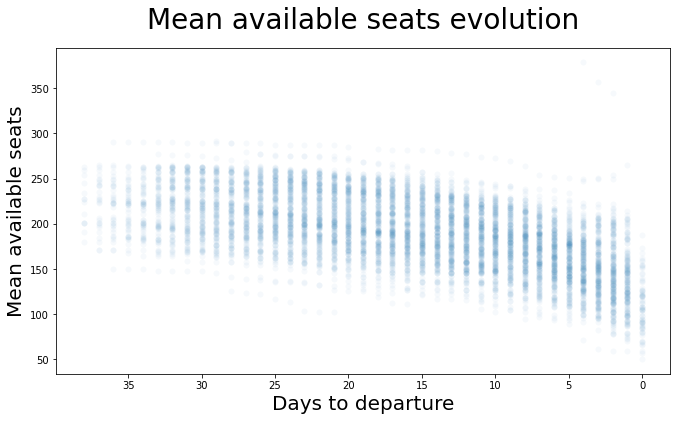

In [13]:
train_ids = (
    data.groupby("train_id")["price_change"]
    .max()
    .reset_index()
    .sort_values(by=["price_change"])
    .reset_index(drop=True)
    .loc[:, "train_id"]
    .values
)
plt.figure(figsize=(11, 6))

sns.scatterplot(
    data=data.loc[data["train_id"].isin(train_ids)],
    x="days_till_dep",
    y="mean_econ_seats",
    estimator="mean",
    alpha=0.04
)

plt.gca().invert_xaxis()

plt.xlabel("Days to departure", fontsize=20, fontweight=450)
plt.ylabel("Mean available seats", fontsize=20, fontweight=450)

plt.title("Mean available seats evolution", fontsize=28, y=1.04)

plt.savefig("figures/available_seats_evolution", dpi=300)
plt.show()

In [ ]:
# differentiate big and small trains, work with small
max_seats = data.groupby("train_id")["mean_econ_seats"].max().reset_index()


data_small =data.loc[
    data["train_id"].isin(
        list(max_seats.loc[max_seats["mean_econ_seats"] < 330]["train_id"])
    )
]

data_big =data.loc[
    data["train_id"].isin(
        list(max_seats.loc[max_seats["mean_econ_seats"] > 350]["train_id"])
    )
]

In [ ]:
data = data_small

In [14]:
len(data["train_id"].unique())

227

In [15]:
price_changed = data.groupby("train_id")["price_change"].sum().reset_index().round(2)
price_changed["price_change"].value_counts()

13.10    44
19.25    39
6.90     31
0.00     24
25.45    14
12.35     9
6.20      8
18.55     6
15.80     4
6.15      3
14.65     2
2.66      2
15.89     2
21.41     2
20.85     2
23.15     2
31.60     2
6.91      1
12.07     1
6.92      1
20.27     1
12.24     1
15.47     1
9.27      1
25.46     1
25.44     1
9.28      1
7.27      1
7.19      1
18.74     1
21.63     1
16.95     1
15.42     1
28.76     1
15.45     1
15.66     1
27.20     1
11.95     1
7.93      1
11.22     1
11.38     1
9.33      1
15.01     1
19.26     1
16.49     1
10.59     1
15.11     1
17.52     1
Name: price_change, dtype: int64

In [16]:
data["price_change_direction"] = np.where(
    data["price_change_percentage"] > 0,
    1,
    np.where(data["price_change_percentage"] < 0, -1, 0),
)
data["price_increase"] = np.where(data["price_change_percentage"] > 0, 1, 0)

In [17]:
data["seats_sold_prev_day"] = data.sort_values(by=["train_id", "days_till_dep"])[
    "econ_seats_sold"
].shift(-2)

data["sales_prev_day"] = data["seats_sold_prev_day"] > 0

In [18]:
data["max_seat_capacity"] = 313

data["capacity"] = data["mean_econ_seats"]/data["max_seat_capacity"]

data["loading_factor"] = (
    (data["max_seat_capacity"] - data["mean_econ_seats"]) / data["max_seat_capacity"]
).round(2)

###ezeket benne van hogy ki kell baszni
drop_trains = data.loc[(data["days_till_dep"] < 5) & (data["capacity"] > 0.75),"train_id"].unique()

data = data.loc[~data["train_id"].isin(drop_trains)].reset_index(drop=True)
###


data["loading_factor_round"] = (
    (data["max_seat_capacity"] - data["mean_econ_seats"]) / data["max_seat_capacity"]
).round(1)

data["loading_factor_cat"] = np.where(
    data["loading_factor"] > data["loading_factor"].median(), "high", "low"
)

In [19]:
data.to_pickle("/Users/vigadam/Documents/github/renfe-analysis/data/MAD_SEV_small_trains_features.pkl")

___

In [70]:
data = pd.concat(
    [
        pd.read_pickle(
            "/Users/vigadam/Documents/github/renfe-analysis/data/3_features/MAD_BAR_small_trains_features.pkl"
        ),
        pd.read_pickle(
            "/Users/vigadam/Documents/github/renfe-analysis/data/3_features/MAD_COR_small_trains_features.pkl"
        ),
        pd.read_pickle(
            "/Users/vigadam/Documents/github/renfe-analysis/data/3_features/MAD_ZAR_small_trains_features.pkl"
        ),
        pd.read_pickle(
            "/Users/vigadam/Documents/github/renfe-analysis/data/3_features/MAD_SEV_small_trains_features.pkl"
        ),
    ]
).reset_index(drop=True)

In [71]:
data["route"] = [data.loc[i, "train_id"][:-38] for i in range(data.shape[0])]

In [72]:
data["route"] = data["route"].astype("category")

In [73]:
data.to_pickle("data/data_work.pkl")

## Figures

In [108]:
data = pd.read_pickle("data/data_work.pkl")

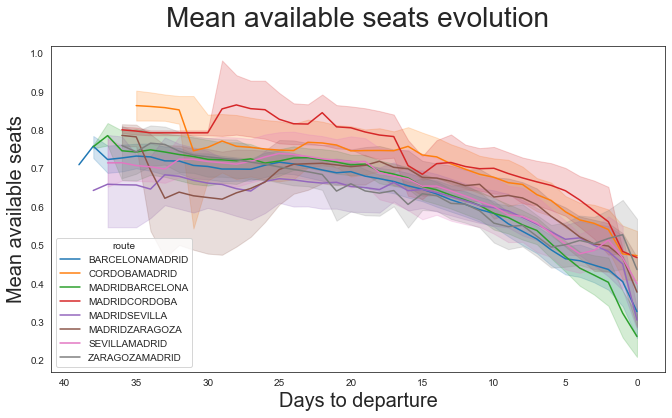

In [121]:
figdata = data.loc[
    data["train_id"].isin(
        data.groupby("train_id")["price_change_percentage"]
        .sum()
        .reset_index()
        .sort_values(by="price_change_percentage")
        .query("price_change_percentage == 0")["train_id"]
    )
]

plt.figure(figsize=(11, 6))

sns.lineplot(
    data=figdata,
    x="days_till_dep",
    y="capacity",
    estimator="mean",
    hue="route",
)#.get_legend().remove()


plt.gca().invert_xaxis()

plt.xlabel("Days to departure", fontsize=20, fontweight=450)
plt.ylabel("Mean available seats", fontsize=20, fontweight=450)

plt.title("Mean available seats evolution", fontsize=28, y=1.04)

plt.savefig("figures/available_seats_evolution", dpi=300)
plt.show()

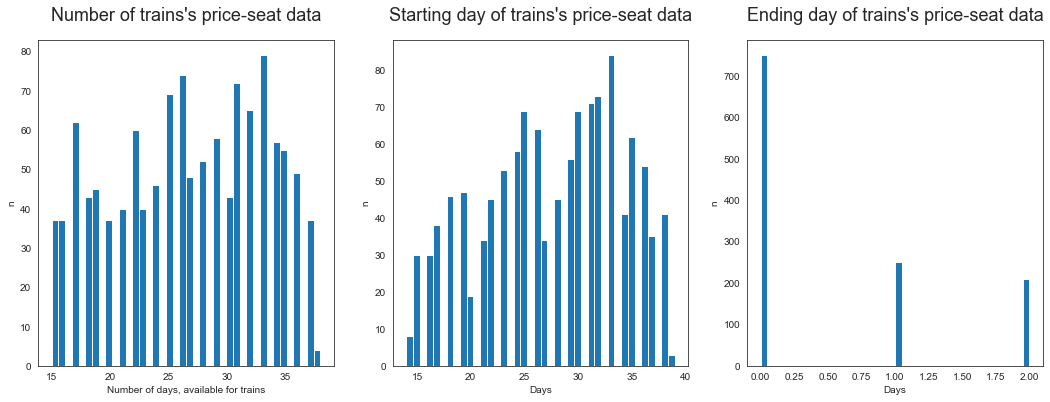

In [42]:
figdata = data.sort_values(by=["train_id", "days_till_dep"]).groupby("train_id")[
    "days_till_dep"
]

plt.figure(figsize=(18, 6))

ax1 = plt.subplot(1, 3, 1)
#ax1.set_xlim(13, 35)
# ax1.set_ylim(0,50)
ax1.hist(figdata.count(), bins=40)
plt.xlabel("Number of days, available for trains", fontsize=10, fontweight=450)
plt.ylabel("n", fontsize=10, fontweight=450)

plt.title("Number of trains's price-seat data", fontsize=18, y=1.04)


ax2 = plt.subplot(1, 3, 2)
# ax2.set_xlim(35, 110)
# ax2.set_ylim(0, 0.14)
ax2.hist(figdata.last(), bins=40)
plt.xlabel("Days", fontsize=10, fontweight=450)
plt.ylabel("n", fontsize=10, fontweight=450)

plt.title(
    "Starting day of trains's price-seat data", fontsize=18, y=1.04
)


ax3 = plt.subplot(1, 3, 3)
# ax3.set_xlim(35, 110)
# ax3.set_ylim(0, 0.14)
ax3.hist(figdata.first(), bins=40)
plt.xlabel("Days", fontsize=10, fontweight=450)
plt.ylabel("n", fontsize=10, fontweight=450)

plt.title(
    "Ending day of trains's price-seat data", fontsize=18, y=1.04
)

plt.savefig("figures/days_plots", dpi=300)

plt.show()

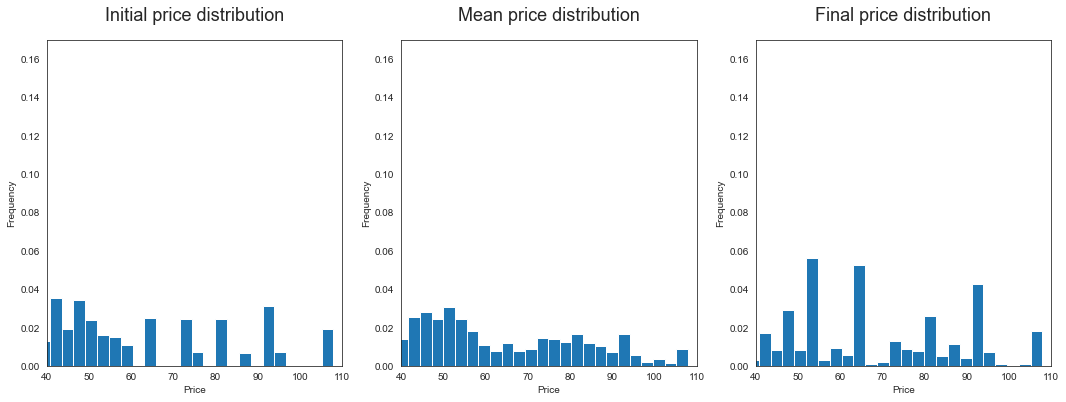

In [46]:
figdata = data.sort_values(by=["train_id", "days_till_dep"]).groupby("train_id")[
    "mean_econ_price"
]

plt.figure(figsize=(18, 6))

xlim_min = 40
xlim_max = 110
ylim_min = 0
ylim_max = 0.17

ax1 = plt.subplot(1, 3, 1)
ax1.set_xlim(xlim_min, xlim_max)
ax1.set_ylim(ylim_min, ylim_max)
ax1.hist(figdata.last(), bins=30, density=True)
plt.xlabel("Price", fontsize=10, fontweight=450)
plt.ylabel("Frequency", fontsize=10, fontweight=450)

plt.title("Initial price distribution", fontsize=18, y=1.04)


ax2 = plt.subplot(1, 3, 2)
ax2.set_xlim(xlim_min, xlim_max)
ax2.set_ylim(ylim_min, ylim_max)
ax2.hist(figdata.mean(), bins=30, density=True)
plt.xlabel("Price", fontsize=10, fontweight=450)
plt.ylabel("Frequency", fontsize=10, fontweight=450)

plt.title("Mean price distribution", fontsize=18, y=1.04)


ax3 = plt.subplot(1, 3, 3)
ax3.set_xlim(xlim_min, xlim_max)
ax3.set_ylim(ylim_min, ylim_max)
ax3.hist(figdata.first(), bins=30, density=True)
plt.xlabel("Price", fontsize=10, fontweight=450)
plt.ylabel("Frequency", fontsize=10, fontweight=450)

plt.title("Final price distribution", fontsize=18, y=1.04)

plt.savefig("figures/price_distributions", dpi=300)

plt.show()

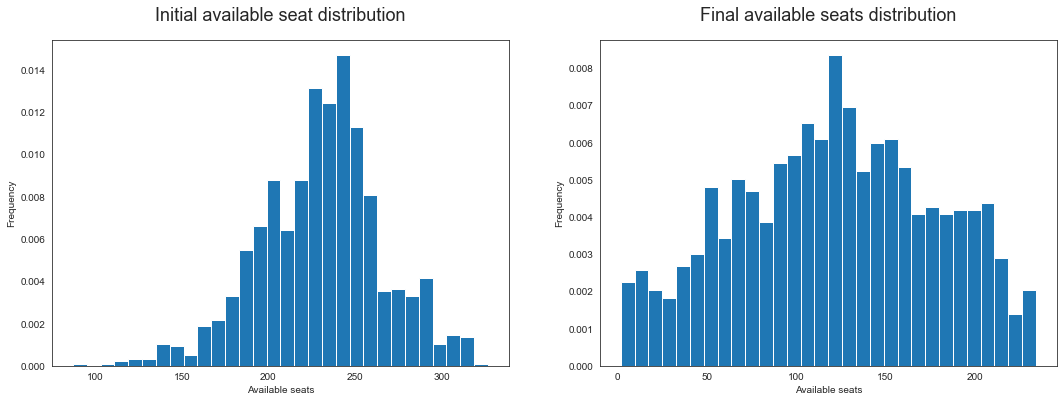

In [47]:
figdata = data.sort_values(by=["train_id", "days_till_dep"]).groupby("train_id")[
    "mean_econ_seats"
]

plt.figure(figsize=(18, 6))

ax1 = plt.subplot(1, 2, 1)
#ax1.set_xlim(35, 110)
#ax1.set_ylim(0, 0.14)
ax1.hist(figdata.last(), bins=30, density=True)
plt.xlabel("Available seats", fontsize=10, fontweight=450)
plt.ylabel("Frequency", fontsize=10, fontweight=450)

plt.title("Initial available seat distribution", fontsize=18, y=1.04)


ax3 = plt.subplot(1, 2, 2)
#ax3.set_xlim(35, 110)
#ax3.set_ylim(0, 0.14)
ax3.hist(figdata.first(), bins=30, density=True)
plt.xlabel("Available seats", fontsize=10, fontweight=450)
plt.ylabel("Frequency", fontsize=10, fontweight=450)

plt.title("Final available seats distribution", fontsize=18, y=1.04)

plt.savefig("figures/price_distributions", dpi=300)

plt.show()

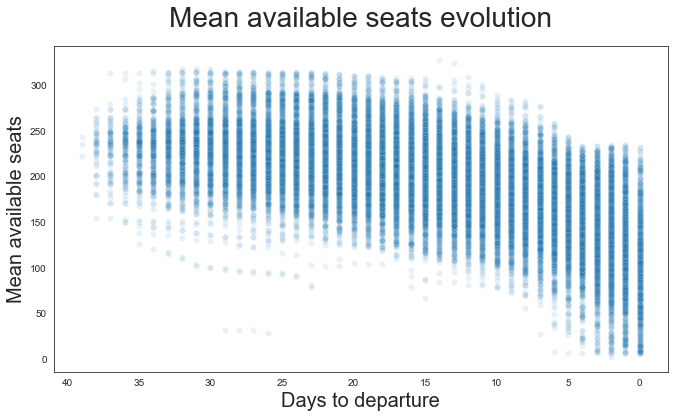

In [48]:
train_ids = (
    data.groupby("train_id")["price_change"]
    .max()
    .reset_index()
    .sort_values(by=["price_change"])
    .reset_index(drop=True)
    .loc[:, "train_id"]
    .values
)
plt.figure(figsize=(11, 6))

sns.scatterplot(
    data=data.loc[data["train_id"].isin(train_ids)],
    x="days_till_dep",
    y="mean_econ_seats",
    alpha=0.1
    #hue="train_id",
)#.get_legend().remove()


plt.gca().invert_xaxis()

plt.xlabel("Days to departure", fontsize=20, fontweight=450)
plt.ylabel("Mean available seats", fontsize=20, fontweight=450)

plt.title("Mean available seats evolution", fontsize=28, y=1.04)

plt.savefig("figures/available_seats_evolution", dpi=300)
plt.show()

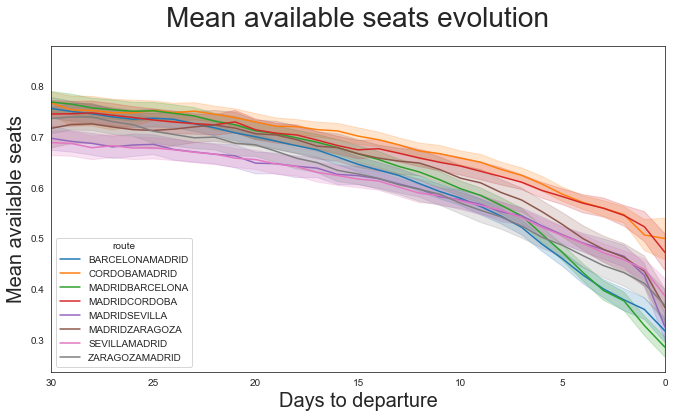

In [125]:
plt.figure(figsize=(11, 6))

sns.lineplot(data=data, x="days_till_dep", y="capacity", estimator="mean", hue="route")

plt.xlim(30, 0)

plt.xlabel("Days to departure", fontsize=20, fontweight=450)
plt.ylabel("Mean available seats", fontsize=20, fontweight=450)

plt.title("Mean available seats evolution", fontsize=28, y=1.04)

plt.savefig("figures/available_seats_evolution", dpi=300)
plt.show()

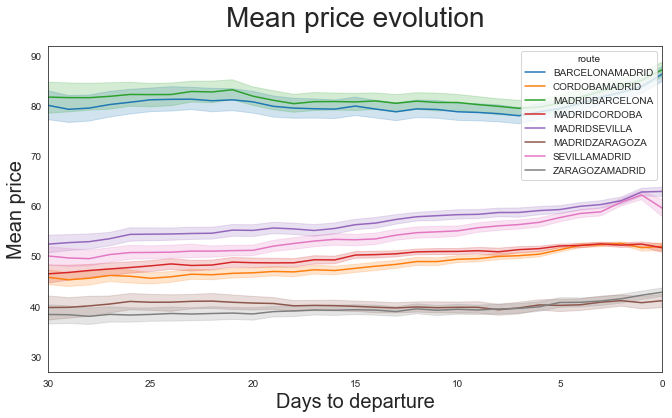

In [50]:
plt.figure(figsize=(11, 6))

sns.lineplot(
    data=data,
    x="days_till_dep",
    y="mean_econ_price",
    estimator="mean",
    hue="route",
)#.get_legend().remove()


plt.gca().invert_xaxis()

plt.xlabel("Days to departure", fontsize=20, fontweight=450)
plt.ylabel("Mean price", fontsize=20, fontweight=450)

plt.xlim(30,0)
#plt.ylim(75,90)

plt.title("Mean price evolution", fontsize=28, y=1.04)

plt.savefig("figures/mean price evolution", dpi=300)
plt.show()

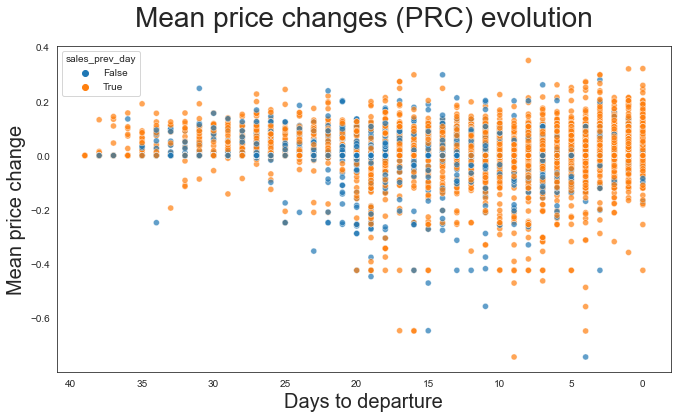

In [51]:
train_ids = (
    data.groupby("train_id")["price_change"]
    .max()
    .reset_index()
    .sort_values(by=["price_change"])
    .reset_index(drop=True)
    .loc[:, "train_id"]
    .values
)
plt.figure(figsize=(11, 6))

sns.scatterplot(
    data=data.loc[data["train_id"].isin(train_ids)],
    x="days_till_dep",
    y="price_change_percentage",
    estimator="mean",
    hue="sales_prev_day",
    alpha=0.7,
)  # .get_legend().remove()


plt.gca().invert_xaxis()

plt.xlabel("Days to departure", fontsize=20, fontweight=450)
plt.ylabel("Mean price change", fontsize=20, fontweight=450)

plt.title("Mean price changes (PRC) evolution", fontsize=28, y=1.04)

plt.savefig("figures/mean price (PRC) changes", dpi=300)
plt.show()

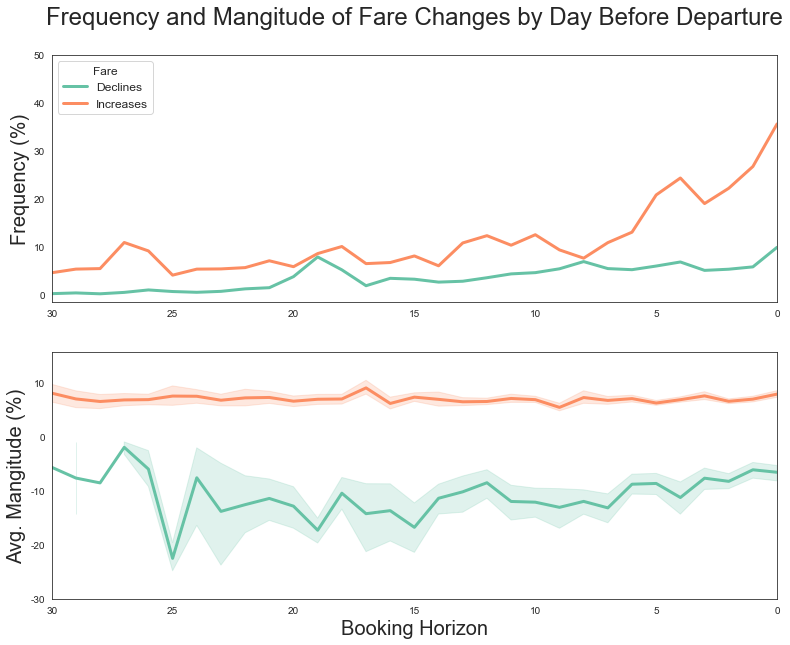

In [62]:
plt.figure(figsize=(13, 10))


figdata = (
    pd.DataFrame(data.groupby("days_till_dep")["price_change_direction"].value_counts())
    .rename(columns={"price_change_direction": "sum"})
    .reset_index()
)

figdata = figdata.merge(
    figdata.groupby("days_till_dep")["sum"]
    .sum()
    .reset_index()
    .rename(columns={"sum": "all"}),
    on="days_till_dep",
)

figdata["price_change_freq"] = figdata["sum"] / figdata["all"]

figdata = figdata.loc[figdata["price_change_direction"] != 0]

# TOP FIG.
ax1 = plt.subplot(2, 1, 1)

sns.lineplot(
    data=figdata,
    x="days_till_dep",
    y="price_change_freq",
    hue="price_change_direction",
    palette="Set2",
    linewidth=3,
    ax=ax1,
)

plt.gca().invert_xaxis()

plt.xlabel("", fontsize=0, fontweight=450)
plt.ylabel("Frequency (%)", fontsize=20, fontweight=450)
plt.title(
    "Frequency and Mangitude of Fare Changes by Day Before Departure",
    fontsize=24,
    y=1.1,
)


ax1.legend(("Declines", "Increases"), loc="upper left", prop={"size": 12}).set_title(
    "Fare", prop={"size": 12}
)

tick_max = 0.5
tick_interval = 0.1
ax1.set_yticks(np.arange(0, tick_max + tick_interval, tick_interval))
ax1.set_yticklabels(np.arange(0, 60, 10))
ax1.set_xlim(30, 0)


# BOTTOM FIG.
figdata_2 = data.loc[data["price_change_direction"] != 0]

ax2 = plt.subplot(2, 1, 2)
sns.lineplot(
    data=figdata_2,
    x="days_till_dep",
    y="price_change_percentage",
    estimator="mean",
    hue="price_change_direction",
    palette="Set2",
    linewidth=3,
    ax=ax2,
).get_legend().remove()

plt.gca().invert_xaxis()

plt.xlabel("Booking Horizon", fontsize=20, fontweight=450)
plt.ylabel("Avg. Mangitude (%)", fontsize=20, fontweight=450)


tick_max = 0.1
tick_min = -0.3
tick_interval = 0.1

ax2.set_yticks(np.arange(tick_min, tick_max + tick_interval, tick_interval))
ax2.set_yticklabels(
    np.arange(int(tick_min * 100), int(tick_max * 100 + 1), int(tick_interval * 100))
)
ax2.set_xlim(30, 0)


plt.savefig("figures/freq_and_magn_of_fare_changes", dpi=300)
plt.show()

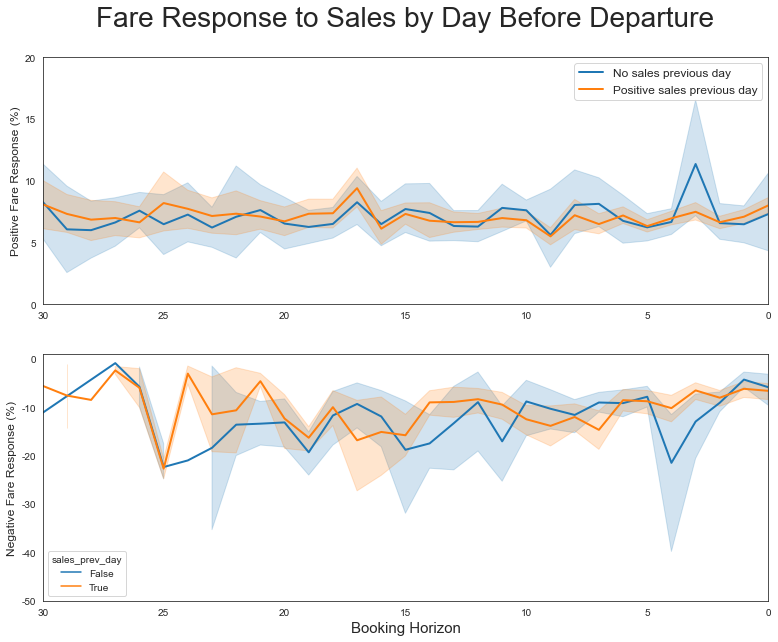

In [53]:
plt.figure(figsize=(13, 10))


# TOP FIG
ax1 = plt.subplot(2, 1, 1)

figdata = data.loc[data["price_change_direction"] > 0]


sns.lineplot(
    data=figdata,
    x="days_till_dep",
    y="price_change_percentage",
    estimator="mean",
    hue="sales_prev_day",
    #ci=False,
    ax=ax1,
    linewidth=2,
)  # .get_legend().remove()


plt.gca().invert_xaxis()

plt.xlabel("", fontsize=20, fontweight=450)
plt.ylabel("Positive Fare Response (%)", fontsize=12, fontweight=450)


ax1.legend(
    ("No sales previous day", "Positive sales previous day"),
    loc="upper right",
    prop={"size": 12},
)  # .set_title("", prop={"size": 0})


tick_max = 0.2
tick_min = 0
tick_interval = 0.05

ax1.set_yticks(np.arange(tick_min, tick_max + tick_interval, tick_interval))
ax1.set_yticklabels(
    np.arange(int(tick_min * 100), int(tick_max * 100 + 1), int(tick_interval * 100))
)
ax1.set_xlim(30, 0)

plt.title("Fare Response to Sales by Day Before Departure", fontsize=28, y=1.1)

# TOP
ax2 = plt.subplot(2, 1, 2)

figdata_2 = data.loc[data["price_change_direction"] < 0]


sns.lineplot(
    data=figdata_2,
    x="days_till_dep",
    y="price_change_percentage",
    estimator="mean",
    hue="sales_prev_day",
    #ci=False,
    ax=ax2,
    linewidth=2,
)#.get_legend().remove()


plt.gca().invert_xaxis()

plt.xlabel("Booking Horizon", fontsize=15, fontweight=450)
plt.ylabel("Negative Fare Response (%)", fontsize=12, fontweight=450)


tick_max = 0
tick_min = -0.5
tick_interval = 0.1

ax2.set_yticks(np.arange(tick_min, tick_max + tick_interval, tick_interval))
ax2.set_yticklabels(
    np.arange(int(tick_min * 100), int(tick_max * 100 + 1), int(tick_interval * 100))
)
ax2.set_xlim(30, 0)

plt.title("", fontsize=0, y=1.04)

plt.savefig("figures/fare_response", dpi=300)
plt.show()

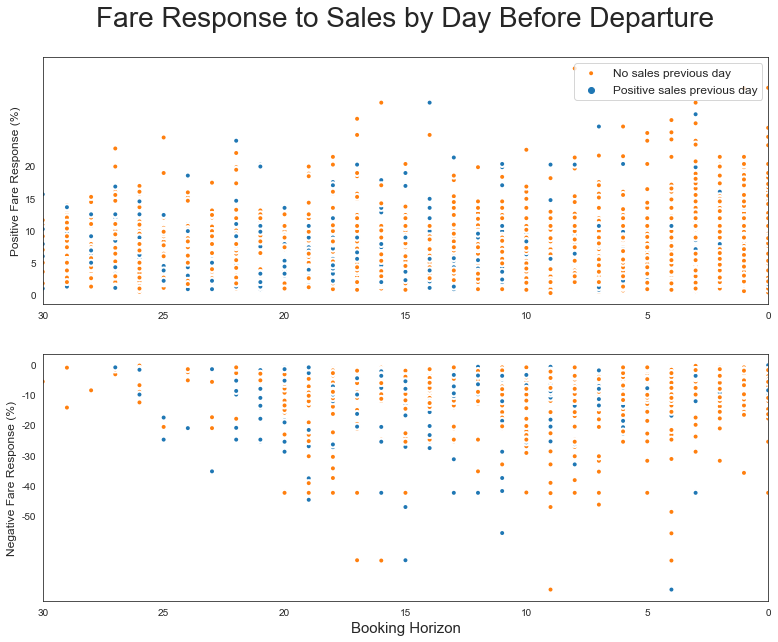

In [54]:
plt.figure(figsize=(13, 10))


# TOP FIG
ax1 = plt.subplot(2, 1, 1)

figdata = data.loc[data["price_change_direction"] > 0]


sns.scatterplot(
    data=figdata,
    x="days_till_dep",
    y="price_change_percentage",
    estimator="mean",
    hue="sales_prev_day",
    ci=False,
    ax=ax1,
    linewidth=2,
)  # .get_legend().remove()


plt.gca().invert_xaxis()

plt.xlabel("", fontsize=20, fontweight=450)
plt.ylabel("Positive Fare Response (%)", fontsize=12, fontweight=450)


ax1.legend(
    ("No sales previous day", "Positive sales previous day"),
    loc="upper right",
    prop={"size": 12},
)  # .set_title("", prop={"size": 0})


tick_max = 0.2
tick_min = 0
tick_interval = 0.05

ax1.set_yticks(np.arange(tick_min, tick_max + tick_interval, tick_interval))
ax1.set_yticklabels(
    np.arange(int(tick_min * 100), int(tick_max * 100 + 1), int(tick_interval * 100))
)
ax1.set_xlim(30, 0)

plt.title("Fare Response to Sales by Day Before Departure", fontsize=28, y=1.1)

# TOP
ax2 = plt.subplot(2, 1, 2)

figdata_2 = data.loc[data["price_change_direction"] < 0]


sns.scatterplot(
    data=figdata_2,
    x="days_till_dep",
    y="price_change_percentage",
    estimator="mean",
    hue="sales_prev_day",
    ci=False,
    ax=ax2,
    linewidth=2,
).get_legend().remove()


plt.gca().invert_xaxis()

plt.xlabel("Booking Horizon", fontsize=15, fontweight=450)
plt.ylabel("Negative Fare Response (%)", fontsize=12, fontweight=450)


tick_max = 0
tick_min = -0.5
tick_interval = 0.1

ax2.set_yticks(np.arange(tick_min, tick_max + tick_interval, tick_interval))
ax2.set_yticklabels(
    np.arange(int(tick_min * 100), int(tick_max * 100 + 1), int(tick_interval * 100))
)
ax2.set_xlim(30, 0)

plt.title("", fontsize=0, y=1.04)

plt.savefig("figures/fare_response", dpi=300)
plt.show()

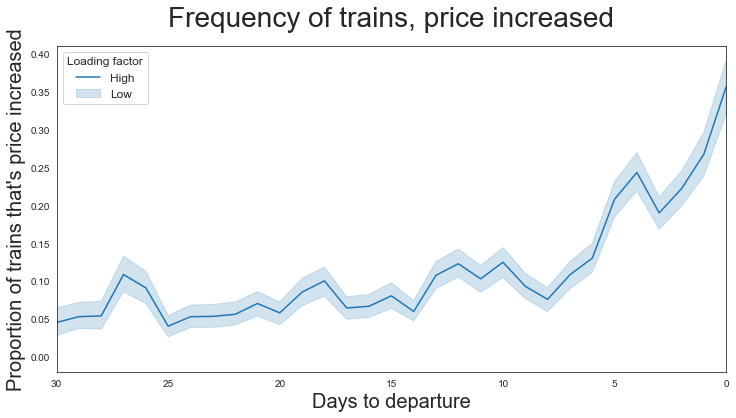

In [55]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.lineplot(
    data=data,
    x="days_till_dep",
    y="price_increase",
    estimator="mean",
    #hue="loading_factor_cat",
)
plt.gca().invert_xaxis()

ax.legend(("High", "Low"), loc="upper left", prop={"size": 12}).set_title(
    "Loading factor", prop={"size": 12}
)

ax.set_xlim(30,0)
plt.xlabel("Days to departure", fontsize=20, fontweight=450)
plt.ylabel("Proportion of trains that's price increased", fontsize=20, fontweight=450)


plt.title("Frequency of trains, price increased", fontsize=28, y=1.04)

plt.savefig("figures/price_change_loading_days", dpi=300)
plt.show()

In [103]:
last_day = data.query("days_till_dep == 3")

last_day["load_cat"] = (
    last_day["loading_factor"]
    > data.groupby("days_till_dep")["loading_factor"]
    .median()
    .reset_index()
    .loc[3, "loading_factor"]
)

last_day.groupby("load_cat")["price_increase"].mean()

<ipython-input-103-4034bb508d96>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_day["load_cat"] = (


load_cat
False    0.132890
True     0.250883
Name: price_increase, dtype: float64

In [91]:
np.where(
    data.query("days_till_dep == 0")["loading_factor"]
    > data.groupby("days_till_dep")["loading_factor"]
    .median()
    .reset_index()
    .loc[0, "loading_factor"],
    "high",
    "low",
)

array(['high', 'high', 'low', 'high', 'low', 'high', 'high', 'high',
       'high', 'low', 'high', 'high', 'high', 'high', 'high', 'high',
       'high', 'high', 'high', 'high', 'high', 'high', 'high', 'low',
       'high', 'high', 'high', 'high', 'high', 'high', 'low', 'high',
       'high', 'low', 'high', 'high', 'high', 'high', 'high', 'high',
       'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high',
       'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high',
       'low', 'high', 'low', 'high', 'high', 'high', 'high', 'high',
       'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high',
       'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high',
       'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high',
       'high', 'low', 'low', 'low', 'low', 'low', 'high', 'high', 'low',
       'low', 'low', 'low', 'high', 'high', 'low', 'low', 'high', 'high',
       'high', 'high', 'high', 'high', 'high', 'high', 'low', 'low',
       'hig

In [92]:
data.groupby("days_till_dep")["loading_factor"].median().reset_index().loc[0,"loading_factor"]

0.66

In [80]:
data.groupby(["days_till_dep", "loading_factor_cat"])["train_id"].count().reset_index().head(25)

,days_till_dep,loading_factor_cat,train_id
0,0,high,718
1,0,low,31
2,1,high,895
3,1,low,73
4,2,high,1046
5,2,low,125
6,3,high,1051
7,3,low,117
8,4,high,1040
9,4,low,106


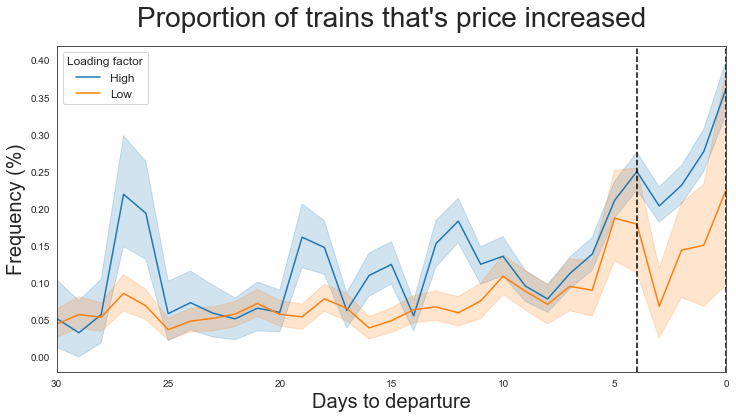

In [61]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.lineplot(
    data=data,
    x="days_till_dep",
    y="price_increase",
    estimator="mean",
    hue="loading_factor_cat",
)
plt.gca().invert_xaxis()

plt.axvline(4, 0, 1, color="black", linestyle="--", linewidth=1.5)
plt.axvline(0, 0, 1, color="black", linestyle="--", linewidth=1.5)

ax.legend(("High", "Low"), loc="upper left", prop={"size": 12}).set_title(
    "Loading factor", prop={"size": 12}
)

ax.set_xlim(30, 0)
plt.xlabel("Days to departure", fontsize=20, fontweight=450)
plt.ylabel("Frequency (%)", fontsize=20, fontweight=450)


plt.title("Proportion of trains that's price increased", fontsize=28, y=1.04)

plt.savefig("figures/price_change_loading_days", dpi=300)
plt.show()

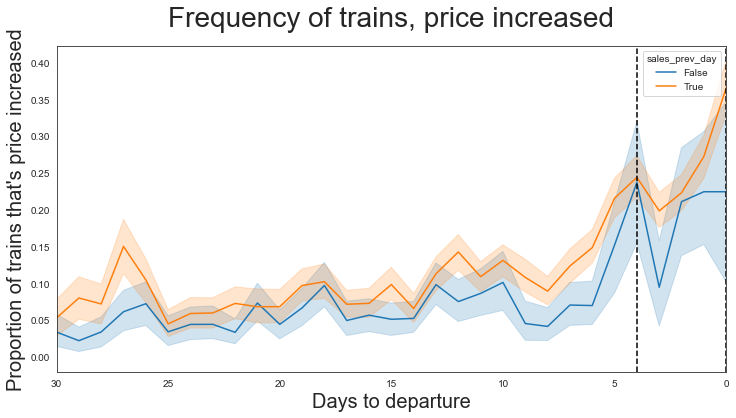

In [59]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.lineplot(
    data=data,
    x="days_till_dep",
    y="price_increase",
    estimator="mean",
    hue="sales_prev_day",
)
plt.gca().invert_xaxis()

plt.axvline(4, 0, 1, color="black", linestyle="--", linewidth=1.5)
plt.axvline(0, 0, 1, color="black", linestyle="--", linewidth=1.5)

#ax.legend(("High", "Low"), loc="upper left", prop={"size": 12}).set_title(
#    "Loading factor", prop={"size": 12}
#)

ax.set_xlim(30, 0)
plt.xlabel("Days to departure", fontsize=20, fontweight=450)
plt.ylabel("Proportion of trains that's price increased", fontsize=20, fontweight=450)


plt.title("Frequency of trains, price increased", fontsize=28, y=1.04)

plt.savefig("figures/price_change_loading_days", dpi=300)
plt.show()

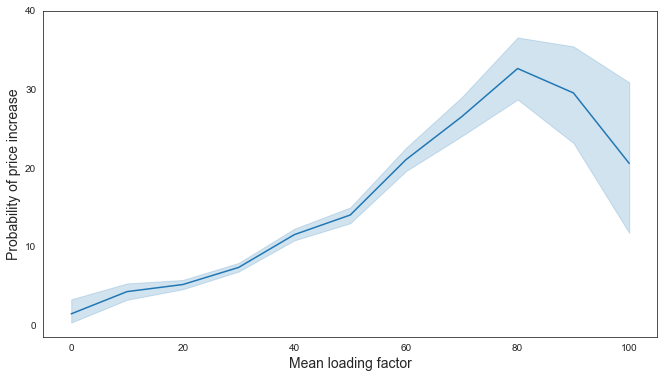

In [60]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(11, 6))

sns.lineplot(
    data=data,
    x="loading_factor_round",
    y="price_increase",
    estimator="mean",
    #hue="sales_prev_day",
)

# plt.gca().invert_xaxis()

plt.xlabel("Mean loading factor", fontsize=14, fontweight=450)
plt.ylabel("Probability of price increase", fontsize=14, fontweight=450)

tick_max = 0.4
tick_min = 0
tick_interval = 0.1

ax.set_yticks(np.arange(tick_min, tick_max + tick_interval, tick_interval))
ax.set_yticklabels(
    np.arange(int(tick_min * 100), int(tick_max * 100 + 1), int(tick_interval * 100))
)

tick_max = 1
tick_min = 0
tick_interval = 0.2

ax.set_xticks(np.arange(tick_min, tick_max + tick_interval, tick_interval))
ax.set_xticklabels(
    np.arange(int(tick_min * 100), int(tick_max * 100 + 1), int(tick_interval * 100))
)

# plt.title("Mean available seats evolution", fontsize=28, y=1.04)
plt.show()

___

# Statistical models

In [ ]:
data = pd.read_pickle("data/small_trains_feature.pkl")
data["days_till_dep"] = data["days_till_dep"].astype("category")
data["weekday"] = data["weekday"].astype("category")

In [ ]:
import statsmodels.api as sm 

In [63]:
data["train_id"].nunique()

1209

In [64]:
data["days_till_dep"] = data["days_till_dep"].astype("category")
data["weekday"] = data["weekday"].astype("category")

In [65]:
data = data.reset_index(drop=True)

In [66]:
# utolsó 5 nap
model = smf.logit(
    "price_increase ~ loading_factor + weekday + route + duration + sales_prev_day",
    data=data.loc[data["days_till_dep"].isin(range(0,5))],
)

log_reg = model.fit(
    cov_type="cluster",
    cov_kwds={"groups": data.loc[model.data.row_labels, "train_id"]},
)

log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.541502
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         price_increase   No. Observations:                 5202
Model:                          Logit   Df Residuals:                     5185
Method:                           MLE   Df Model:                           16
Date:                Tue, 08 Dec 2020   Pseudo R-squ.:                 0.03211
Time:                        21:28:50   Log-Likelihood:                -2816.9
converged:                       True   LL-Null:                       -2910.3
Covariance Type:              cluster   LLR p-value:                 3.470e-31
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -3.3143      0.605     -5.479      0.000      -4.500      -2.129
weekday[T.1]                 0.1372      0.126      1.091      0.275      -0.109       0.384
weekday[T.2]                -0.0095      0.136     -0.070      0.944      -0.275       0.256
weekday[T.3]                -0.0406      0.163     -0.249      0.803      -0.360       0.279
weekday[T.4]                 0.2454      0.165      1.489      0.137      -0.078       0.568
weekday[T.5]                 0.4334      0.138      3.144      0.002       0.163       0.704
weekday[T.6]                -0.4309      0.198     -2.174      0.030      -0.819      -0.042
route[T.CORDOBAMADRID]       0.2104      0.258      0.816      0.414      -0.295       0.716
route[T.MADRIDBARCELONA]     0.0963      0.115      0.838      0.402      -0.129       0.322
route[T.MADRIDCORDOBA]      -0.0580      0.279     -0.208      0.836      -0.605       0.489
route[T.MADRIDSEVILLA]       0.1733      0.159      1.089      0.276      -0.139       0.485
route[T.MADRIDZARAGOZA]     -0.0041      0.349     -0.012      0.991      -0.688       0.680
route[T.SEVILLAMADRID]       0.6455      0.153      4.220      0.000       0.346       0.945
route[T.ZARAGOZAMADRID]      0.1885      0.319      0.590      0.555      -0.438       0.815
sales_prev_day[T.True]       0.4188      0.127      3.302      0.001       0.170       0.667
loading_factor               1.9435      0.261      7.438      0.000       1.431       2.456
duration                     0.1931      0.205      0.941      0.347      -0.209       0.595
============================================================================================
"""

In [107]:
# utolsó 1 nap
model = smf.logit(
    "price_increase ~ loading_factor + weekday + route + duration + sales_prev_day",
    data=data.loc[data["days_till_dep"].isin(range(4, 5))],
)

log_reg = model.fit(
    cov_type="cluster",
    cov_kwds={"groups": data.loc[model.data.row_labels, "train_id"]},
)

log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.541087
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         price_increase   No. Observations:                 1146
Model:                          Logit   Df Residuals:                     1134
Method:                           MLE   Df Model:                           11
Date:                Tue, 08 Dec 2020   Pseudo R-squ.:                 0.02512
Time:                        22:12:27   Log-Likelihood:                -620.09
converged:                       True   LL-Null:                       -636.06
Covariance Type:              cluster   LLR p-value:                 0.0007748
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -4.3454      1.119     -3.883      0.000      -6.539      -2.152
route[T.CORDOBAMADRID]       1.5732      0.450      3.499      0.000       0.692       2.455
route[T.MADRIDBARCELONA]     0.0428      0.210      0.203      0.839      -0.369       0.455
route[T.MADRIDCORDOBA]       1.1338      0.491      2.308      0.021       0.171       2.097
route[T.MADRIDSEVILLA]       0.2465      0.300      0.822      0.411      -0.341       0.834
route[T.MADRIDZARAGOZA]      0.7087      0.643      1.103      0.270      -0.551       1.968
route[T.SEVILLAMADRID]       0.6850      0.271      2.527      0.012       0.154       1.216
route[T.ZARAGOZAMADRID]      0.7961      0.598      1.331      0.183      -0.376       1.968
sales_prev_day[T.True]       0.0136      0.244      0.056      0.956      -0.465       0.493
loading_factor               2.2598      0.556      4.065      0.000       1.170       3.349
weekday                     -0.0036      0.038     -0.094      0.925      -0.078       0.071
duration                     0.6520      0.378      1.725      0.084      -0.089       1.393
============================================================================================
"""

In [68]:
model = smf.logit(
    "price_increase ~ loading_factor + weekday + route + duration + sales_prev_day",
    data=data.loc[data["days_till_dep"].isin(range(5, 10))],
)

log_reg = model.fit(
    cov_type="cluster",
    cov_kwds={"groups": data.loc[model.data.row_labels, "train_id"]},
)

log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.362592
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         price_increase   No. Observations:                 5708
Model:                          Logit   Df Residuals:                     5691
Method:                           MLE   Df Model:                           16
Date:                Tue, 08 Dec 2020   Pseudo R-squ.:                 0.03192
Time:                        21:29:22   Log-Likelihood:                -2069.7
converged:                       True   LL-Null:                       -2137.9
Covariance Type:              cluster   LLR p-value:                 3.499e-21
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -4.7918      0.816     -5.870      0.000      -6.392      -3.192
weekday[T.1]                 0.1695      0.158      1.072      0.284      -0.140       0.480
weekday[T.2]                 0.1684      0.166      1.015      0.310      -0.157       0.494
weekday[T.3]                -0.0024      0.195     -0.012      0.990      -0.384       0.379
weekday[T.4]                -0.1593      0.201     -0.795      0.427      -0.552       0.234
weekday[T.5]                 0.0032      0.169      0.019      0.985      -0.328       0.334
weekday[T.6]                -0.2378      0.241     -0.985      0.325      -0.711       0.235
route[T.CORDOBAMADRID]       1.0265      0.325      3.159      0.002       0.390       1.663
route[T.MADRIDBARCELONA]    -0.0567      0.158     -0.359      0.720      -0.367       0.253
route[T.MADRIDCORDOBA]       0.7882      0.346      2.275      0.023       0.109       1.467
route[T.MADRIDSEVILLA]      -0.0008      0.210     -0.004      0.997      -0.412       0.410
route[T.MADRIDZARAGOZA]      0.3487      0.461      0.756      0.449      -0.555       1.252
route[T.SEVILLAMADRID]       0.5756      0.179      3.211      0.001       0.224       0.927
route[T.ZARAGOZAMADRID]      0.5627      0.425      1.324      0.186      -0.270       1.396
sales_prev_day[T.True]       0.8091      0.122      6.613      0.000       0.569       1.049
loading_factor               2.2563      0.415      5.437      0.000       1.443       3.070
duration                     0.3330      0.281      1.187      0.235      -0.217       0.883
============================================================================================
"""

In [69]:
model = smf.logit(
    "price_increase ~ loading_factor + weekday + route + duration + sales_prev_day",
    data=data.loc[data["days_till_dep"].isin(range(10, 15))],
)

log_reg = model.fit(
    cov_type="cluster",
    cov_kwds={"groups": data.loc[model.data.row_labels, "train_id"]},
)

log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.315949
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         price_increase   No. Observations:                 5674
Model:                          Logit   Df Residuals:                     5657
Method:                           MLE   Df Model:                           16
Date:                Tue, 08 Dec 2020   Pseudo R-squ.:                 0.05333
Time:                        21:29:27   Log-Likelihood:                -1792.7
converged:                       True   LL-Null:                       -1893.7
Covariance Type:              cluster   LLR p-value:                 3.165e-34
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -4.0353      0.992     -4.066      0.000      -5.980      -2.090
weekday[T.1]                -0.1776      0.166     -1.067      0.286      -0.504       0.149
weekday[T.2]                -0.6649      0.182     -3.647      0.000      -1.022      -0.308
weekday[T.3]                -0.2267      0.191     -1.189      0.235      -0.600       0.147
weekday[T.4]                -0.8171      0.267     -3.061      0.002      -1.340      -0.294
weekday[T.5]                -0.6724      0.177     -3.791      0.000      -1.020      -0.325
weekday[T.6]                -0.1469      0.262     -0.560      0.575      -0.661       0.367
route[T.CORDOBAMADRID]       1.2795      0.405      3.161      0.002       0.486       2.073
route[T.MADRIDBARCELONA]    -0.0598      0.198     -0.302      0.763      -0.448       0.328
route[T.MADRIDCORDOBA]       1.1257      0.431      2.612      0.009       0.281       1.970
route[T.MADRIDSEVILLA]       0.5895      0.243      2.421      0.015       0.112       1.067
route[T.MADRIDZARAGOZA]      0.1248      0.597      0.209      0.834      -1.045       1.295
route[T.SEVILLAMADRID]       0.6884      0.233      2.954      0.003       0.232       1.145
route[T.ZARAGOZAMADRID]      0.2299      0.552      0.416      0.677      -0.852       1.312
sales_prev_day[T.True]       0.4723      0.109      4.342      0.000       0.259       0.685
loading_factor               3.5123      0.514      6.836      0.000       2.505       4.519
duration                     0.0336      0.352      0.095      0.924      -0.657       0.724
============================================================================================
"""

___

### innentől random modellek

In [ ]:
data = pd.concat(
    [
        data[["train_id", "departure"]],
        data[data.columns.difference(["train_id", "departure"])].astype("float"),
    ],
    axis=1,
)

In [ ]:
data_all = data.set_index(["train_id", "days_till_dep"])

In [ ]:
fe_lm = PanelOLS.from_formula(
    "ln_price ~ ln_econ_seat + TimeEffects + EntityEffects",
    data_all,
    drop_absorbed=True,
).fit(cov_type="clustered", cluster_entity=True)

In [ ]:
fe_lm.summary

In [ ]:
data_all = data

In [ ]:
data_all.loc[data_all["days_till_dep"] == 1].rename(
    columns={"ln_econ_seat": "ln_econ_seat_1"}
)[["train_id", "ln_econ_seat_1"]]

In [ ]:
i= 0

In [ ]:
data_try = data_all.loc[data_all["days_till_dep"] == i].merge(
    data_all.loc[data_all["days_till_dep"] == i+1].rename(
        columns={"ln_econ_seat": "ln_econ_seat_1"}
    )[["train_id", "ln_econ_seat_1"]],
    on="train_id",
)

In [ ]:
data.loc[:, "weekday"] = data.loc[:, "weekday"].astype("category")
data.loc[:, "depart_hour"] = data.loc[:, "depart_hour"].astype("category")

In [ ]:
model = smf.ols(
    formula="ln_price ~ ln_econ_seat  + duration + weekday + depart_hour",
    data=data,
)
OLS_reg = model.fit(
    cov_type="cluster",
    cov_kwds={"groups": data.loc[model.data.row_labels, "train_id"]},
)

In [ ]:
OLS_reg.summary()

In [ ]:
data.loc[:, "days_till_dep"] = data.loc[:, "days_till_dep"].astype("category")
data.loc[:, "weekday"] = data.loc[:, "weekday"].astype("category")
data.loc[:, "depart_hour"] = data.loc[:, "depart_hour"].astype("category")
IV_reg = IVGMM(
    data["ln_price"],
    data[["const", "days_till_dep", "duration"]],
    data["ln_econ_seat"],
    data[["weekday", "depart_hour"]],
).fit(
    cov_type="kernel",
    # cov_kwds={"groups": data.loc[model.data.row_labels, "train_id"]},
)
IV_reg.summary

In [ ]:
data = pd.read_pickle("data/MAD_BAR_features_v2.pkl")

data["price_change"] = data.groupby("train_id")["mean_price"].transform("diff")

train_ids = (
    data.groupby("train_id")["price_change"]
    .max()
    .reset_index()
    .sort_values(by=["price_change"])
    .reset_index(drop=True)
    .loc[:105, "train_id"]
    .values
)
data = data.loc[data["train_id"].isin(train_ids)]

data["days_till_dep"] = data["days_till_dep"].astype(int)
data = data.loc[data["days_till_dep"] < 15].reset_index(drop=True)

data.loc[:, "days_till_dep"] = data.loc[:, "days_till_dep"].astype("category")
data.loc[:, "weekday"] = data.loc[:, "weekday"].astype("category")
data.loc[:, "depart_hour"] = data.loc[:, "depart_hour"].astype("category")
IV_reg = IVGMM(
    data["ln_price"],
    data[["const", "days_till_dep", "duration"]],
    data["ln_econ_seat"],
    data[["weekday", "depart_hour"]],
).fit(
    cov_type="kernel",
    # cov_kwds={"groups": data.loc[model.data.row_labels, "train_id"]},
)
IV_reg.summary

In [ ]:
sns.lineplot(data=pd.DataFrame(IV_reg.params.iloc[1:-2]).reset_index())
plt.gca().invert_xaxis()

In [ ]:
data_all = data_all.reset_index()

In [ ]:
dic_estimate = {}
dic_confidence = {}
for i in range(0, 30):
    data = data_all.loc[data_all["days_till_dep"] == i].merge(
        data_all.loc[data_all["days_till_dep"] == i + 1].rename(
            columns={"ln_econ_seat": "ln_econ_seat_1"}
        )[["train_id", "ln_econ_seat_1"]],
        on="train_id",
    )
    data.loc[:, "weekday"] = data.loc[:, "weekday"].astype("category")
    data.loc[:, "depart_hour"] = data.loc[:, "depart_hour"].astype("category")

    IV_reg = IVGMM(
        data["ln_price"],
        data[["const", "duration"]],
        data["ln_econ_seat"],
        data[["weekday", "depart_hour"]],
    ).fit()

    dic_estimate[i] = IV_reg.params["ln_econ_seat"]
    dic_confidence[i] = IV_reg.conf_int().loc["ln_econ_seat"].values

In [ ]:
estimates = pd.concat(
    [
        pd.DataFrame(dic_confidence).T.rename(columns={0: "lower", 1: "upper"}),
        pd.DataFrame(dic_estimate.values()).rename(columns={0: "estimate"}),
    ],
    axis=1,
).reset_index()

estimates = estimates.loc[0:30, :]
estimates["x"] = 0
plt.plot("index", "estimate", data=estimates, color="blue", linewidth=2)
plt.plot(
    "index", "lower", data=estimates, color="blue", linewidth=1, linestyle="dashed"
)
plt.plot(
    "index", "upper", data=estimates, color="blue", linewidth=1, linestyle="dashed"
)
plt.plot("index", "x", data=estimates, color="black", linewidth=1.5)

In [ ]:
 ln_econ_seat.shift(1) + ln_econ_seat.shift(2)

In [ ]:
dic_estimate = {}
dic_confidence = {}

for i in range(0, 30):
    data = data_all.loc[data_all["days_till_dep"] == i].merge(
        data_all.loc[data_all["days_till_dep"] == i + 1].rename(
            columns={"ln_econ_seat": "ln_econ_seat_1"}
        )[["train_id", "ln_econ_seat_1"]],
        on="train_id",
    )
    data.loc[:, "weekday"] = data.loc[:, "weekday"].astype("category")
    data.loc[:, "depart_hour"] = data.loc[:, "depart_hour"].astype("category")

    model = smf.ols(
        formula="ln_price ~ ln_econ_seat + ln_econ_seat_1 + duration + weekday + depart_hour",
        data=data,
    )
    OLS_reg = model.fit(
        cov_type="cluster",
        cov_kwds={"groups": data.loc[model.data.row_labels, "train_id"]},
    )

    variable = "ln_econ_seat"

    dic_estimate[i] = OLS_reg.params[variable]
    dic_confidence[i] = OLS_reg.conf_int().loc[variable].values

In [ ]:
estimates = pd.concat(
    [
        pd.DataFrame(dic_confidence).T.rename(columns={0: "lower", 1: "upper"}),
        pd.DataFrame(dic_estimate.values()).rename(columns={0: "estimate"}),
    ],
    axis=1,
).reset_index()

estimates = estimates.loc[0:20, :]
estimates["x"] = 0
plt.plot("index", "estimate", data=estimates, color="blue", linewidth=2)
plt.plot(
    "index", "lower", data=estimates, color="blue", linewidth=1, linestyle="dashed"
)
plt.plot(
    "index", "upper", data=estimates, color="blue", linewidth=1, linestyle="dashed"
)
plt.plot("index","x", data=estimates, color="black", linewidth=1.5)